In [130]:
import os
import pandas as pd
import numpy as np

datapath = "finetune_data3/"
dirs = [
    'neutral', 
    'happy' , 'sad', 'angry' ]
# , 'fear', 'disgust']

path_list = []
emotion_list = []

emomap = {}
emomap['happy'] = 0
emomap['neutral'] = 0
emomap['sad'] = 0
emomap['angry'] = 0
emomap['fear'] = 0
emomap['disgust'] = 0


for dir in dirs:
    mood_files = os.listdir(os.path.join(datapath, dir))
    for audio_file in mood_files:
        if emomap[dir] > 60: continue
        emomap[dir] +=1
        path_list.append(f"{datapath}{dir}/{audio_file}")
        emotion_list.append(dir)
###############################################################

####################################################################
finetune_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

finetune_df.tail()

,path,emotion
212,finetune_data3/angry/928989f2964d566454ca37224...,angry
213,finetune_data3/angry/c03241f21383b548e78820c19...,angry
214,finetune_data3/angry/6d00889788eb5dc86bf7516f4...,angry
215,finetune_data3/angry/2bb278d51138ca042dde6b729...,angry
216,finetune_data3/angry/0aad3a076982258c5135201dc...,angry


In [131]:
# TESS = "data/TESS/"
# tess_dir_list = os.listdir(TESS)
# tess_dir_list = os.listdir(TESS)
# path_list = []
# emotion_list = [] 

# emotion_dic = {
#     # 'happy'   : 'happy',
#     # 'neutral' : 'neutral',
#     'sad'     : 'sad',
#     'angry'   : 'angry',
#     'fear'    : 'fear',
#     'disgust'  : 'disgust',
# }

# emomap = {}
# emomap['happy'] = 0
# emomap['neutral'] = 0
# emomap['sad'] = 0
# emomap['angry'] = 0
# emomap['fear'] = 0
# emomap['disgust'] = 0


# for directory in tess_dir_list:
#     audio_files = os.listdir(os.path.join(TESS, directory))
#     for audio_file in audio_files:
#         part = audio_file.split('.')[0]
#         try:key = part.split('_')[2]
#         except Exception: print(part)
#         if key in emotion_dic and emomap[key] < 120:
#             emomap[key] += 1
#             path_list.append(f"{TESS}{directory}/{audio_file}") 
#             emotion_list.append(emotion_dic[key])
            
# tess_df = pd.concat([
#     pd.DataFrame(path_list, columns=['path']),
#     pd.DataFrame(emotion_list, columns=['emotion'])
# ], axis=1)

# tess_df.tail()

# # finetune_df = pd.concat([
# #     tess_df
# # ], axis=0, ignore_index=True)
# # finetune_df.tail()

In [132]:
df = pd.concat([
    finetune_df
    # ,
    # tess_df
], axis=0, ignore_index=True)
df.tail()

,path,emotion
212,finetune_data3/angry/928989f2964d566454ca37224...,angry
213,finetune_data3/angry/c03241f21383b548e78820c19...,angry
214,finetune_data3/angry/6d00889788eb5dc86bf7516f4...,angry
215,finetune_data3/angry/2bb278d51138ca042dde6b729...,angry
216,finetune_data3/angry/0aad3a076982258c5135201dc...,angry


# Preprocess


In [133]:
from pydub import AudioSegment, effects
import librosa

def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    # print(sr)
    padded = np.pad(trimmed, (0, 950000-len(trimmed)), 'constant')
    return padded, sr

emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

# Extract Features

In [134]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except Exception:
        print(f"Failed for path: {row.path}")

In [135]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
print(y)
y = np.expand_dims(y, axis=1).astype('int8')

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


# Import Model

In [136]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import layers, optimizers, callbacks
import keras

In [137]:
import tensorflow as tf; print(len(tf.config.list_physical_devices('GPU')))

1


In [138]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

print(len(X_train), len(X_val))


# X_val = X
# y_val = y
# X_train = X
# y_train = y

# y_train_class = to_categorical(y_train, 6)
# y_val_class = to_categorical(y_val, 6)


173 44


In [139]:
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

/home/catsudon/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 1856, 64)       │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,894 (210.52 KB)

 Trainable params: 53,894 (210.52 KB)

 Non-trainable params: 0 (0.00 B)

None


In [140]:

MODEL = keras.saving.load_model("model.keras")
for layer in MODEL.layers[2:]:
    layer.trainable = False
for layer in MODEL.layers[:2]:
    layer.trainable = True
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
model = MODEL.fit(X_train, y_train_class, epochs=300, batch_size=16, validation_data=(X_val, y_val_class))

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - categorical_accuracy: 0.3146 - loss: 3.0561 - val_categorical_accuracy: 0.6136 - val_loss: 1.3595
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - categorical_accuracy: 0.5424 - loss: 1.6449 - val_categorical_accuracy: 0.5682 - val_loss: 1.3012
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - categorical_accuracy: 0.5393 - loss: 1.5075 - val_categorical_accuracy: 0.5227 - val_loss: 1.6056
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - categorical_accuracy: 0.5626 - loss: 1.2246 - val_categorical_accuracy: 0.6591 - val_loss: 1.5008
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - categorical_accuracy: 0.6516 - loss: 1.0888 - val_categorical_accuracy: 0.6364 - val_loss: 1.1754
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - categorical_accuracy: 0.5960 - loss: 0.9879 - val_categorical_accuracy: 0.6136 - val_loss: 1.2150
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - categorical_accuracy: 0.6501 - lo

# Evaluate

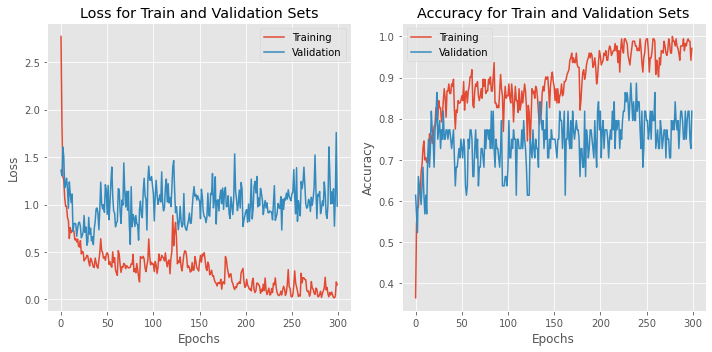

In [141]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
0.8181818181818182


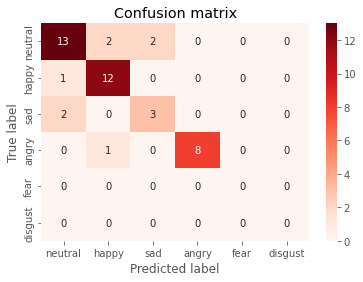

In [142]:
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
accuracy = accuracy_score(y_val, y_pred) ; print(accuracy)
labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label') 
plt.title('Confusion matrix')
plt.show()

In [144]:
MODEL.save('finetuned_model_NHSA.keras')